In [167]:
%matplotlib inline
import pandas as pd

In [356]:
brakepads = pd.read_json("data.json")
print(brakepads.shape)
brakepads.dropna(subset=['classOfPart'], how='any', inplace=True)
print(brakepads.shape)
brakepads.dropna(thresh=4, inplace=True)
print(brakepads.shape)
brakepads[['classOfPart']].astype('category')
print(brakepads.shape)

(4001, 5)
(1440, 5)
(1275, 5)
(1275, 5)


In [297]:
brakepads.isnull().sum()

classOfPart      0
length         232
partNumber       0
thickness        0
width          768
dtype: int64

In [331]:
from impyute.imputation.cs import mice
test = brakepads[['length', 'thickness', 'width']]
test = test.fillna(value=pd.np.nan)
test = test.apply(pd.to_numeric)
imputed_training = mice(test)
imputed_training.columns = ['length', 'thickness', 'width']
imputed_training.head()


C:\ProgramData\Anaconda3\lib\site-packages\impyute\util\preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()


,length,thickness,width
0,108.700000,14.0,88.149554
1,121.623141,16.0,93.100000
2,107.800000,12.9,95.333084
3,103.178536,15.4,53.800000
4,95.000000,15.8,60.782518


In the columns length, thickness and width there is a variation in occurrence. There does not seem to be a correlation between the missing values.

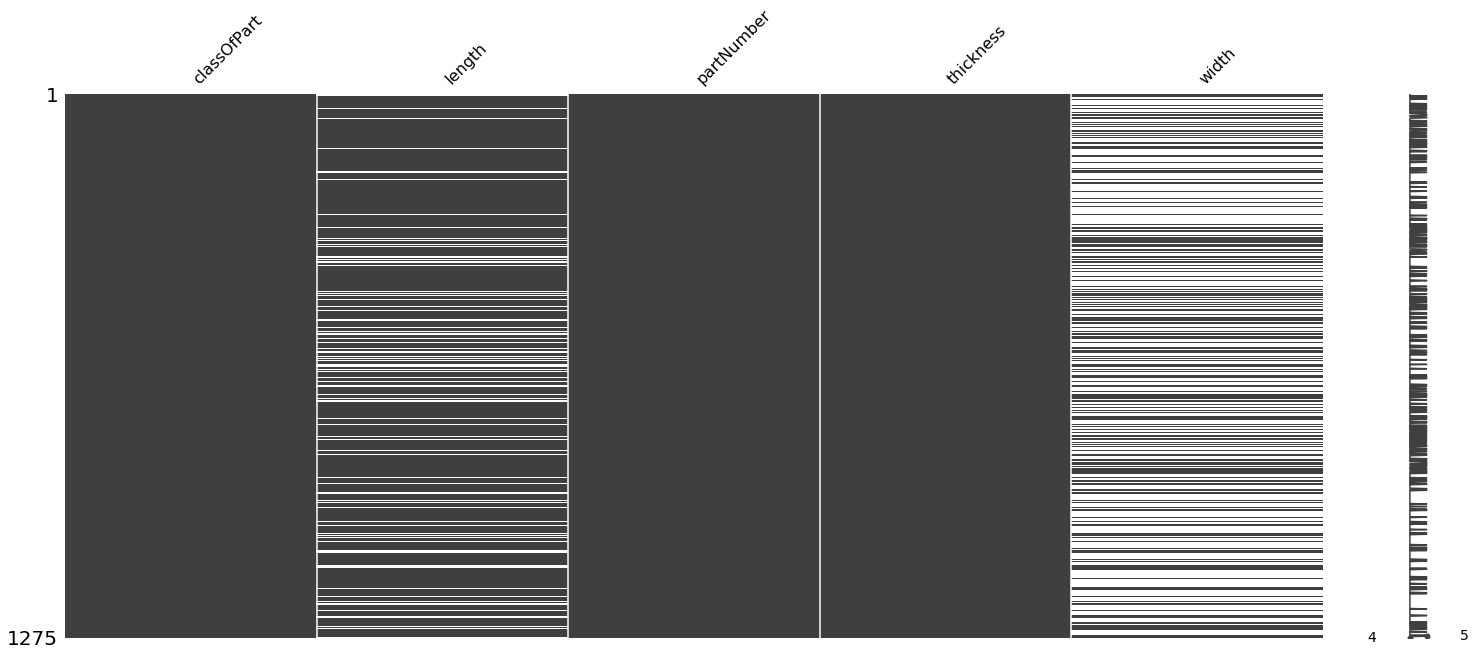

In [246]:
import missingno as msno
msno.matrix(brakepads)

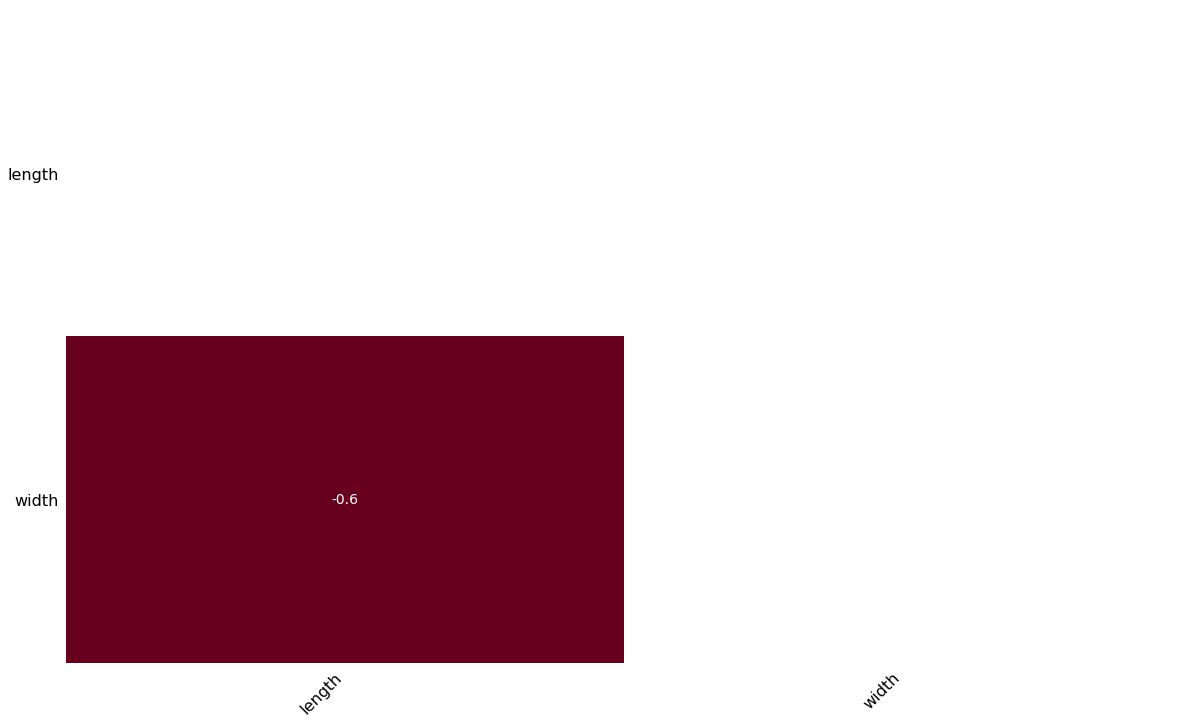

In [247]:
msno.heatmap(brakepads)

In [172]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(brakepads[['length', 'thickness', 'width']])
imputed = imp.transform(brakepads[['length', 'thickness', 'width']])
imputed = pd.DataFrame(data=imputed, columns=['length', 'thickness', 'width'])
imputed['classOfPart'] = brakepads['classOfPart'].tolist()
imputed.tail()
# imputed.assign(classOfPart = brakepads['classOfPart'].tolist())
# imputed['classOfPart'] = pd.Series(np.random.randn(1438), index=imputed.index)
# imputed
# np.append(imputed, brakepads['classOfPart'], axis=1)
# brakepads['classOfPart']
# imputed['classOfPart'] = pd.Series(np.random.randn(sLength), index=df1.index)
# pd.concat([imputed, brakepads['classOfPart']])

,length,thickness,width,classOfPart
1435,122.763605,16.8,90.66849,Vorderachse
1436,122.763605,15.5,110.50000,Hinterachse
1437,122.763605,14.0,107.70000,Hinterachse
1438,122.763605,15.8,90.66849,Hinterachse
1439,122.763605,17.3,137.60000,Vorderachse


In [173]:
imputed['classOfPart'].value_counts()

Vorderachse    907
Hinterachse    533
Name: classOfPart, dtype: int64

## Down-sampling the majority class

In [174]:
from sklearn.utils import resample
majority = imputed[imputed.classOfPart=='Vorderachse']
minority = imputed[imputed.classOfPart=='Hinterachse']
majority_downsampled = resample(majority,replace=False,n_samples=minority.shape[0])
# Add random_state to make results reproducable
downsampled = pd.concat([minority,majority_downsampled])
# downsampled['classOfPart'].value_counts()
downsampled.tail()

,length,thickness,width,classOfPart
936,109.5,18.2,90.66849,Vorderachse
750,130.0,19.3,64.00000,Vorderachse
1382,127.0,15.4,90.66849,Vorderachse
1212,55.7,15.0,90.66849,Vorderachse
151,169.0,18.0,90.66849,Vorderachse


In [138]:
downsampled = downsampled.sample(frac=1)
downsampled.tail()

,length,thickness,width,classOfPart
1099,118.000000,15.6,90.66849,Hinterachse
474,92.400000,14.5,40.80000,Hinterachse
1115,108.800000,18.5,90.66849,Vorderachse
991,122.763605,18.8,90.66849,Vorderachse
389,122.763605,18.0,137.75000,Vorderachse


In [175]:
from sklearn.model_selection import train_test_split
X = downsampled[['length', 'thickness', 'width']]
y = downsampled[['classOfPart']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=35, max_depth=1, random_state=42)
clf.fit(X_train, y_train) 
clf.score(X_test, y_test) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8130841121495327

In [371]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from impyute.imputation.cs import mice

random_state=41

def getPrediction():
    imputed = imputeData(brakepads)
    imputed = imputeDataWithMICE(brakepads)
    downsampled = downsample(imputed)
    X = downsampled[['length', 'thickness', 'width']]
    y = downsampled[['classOfPart']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    result = np.zeros(4)
    result[0] = applyKNN(X_train, X_test, y_train, y_test)
    result[1] = applyLogisticRegression(X_train, X_test, y_train, y_test)
    result[2] = applyRandomForest(X_train, X_test, y_train, y_test)
    result[3] = applySVM(X_train, X_test, y_train, y_test)
    return result

def applyKNN(X_train, X_test, y_train, y_test):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(X_train, np.ravel(y_train))
    return clf.score(X_test, y_test)

def applyLogisticRegression(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver='liblinear', C=0.94)
    clf.fit(X_train, np.ravel(y_train))
    return clf.score(X_test, y_test)
    # tau  - limit the differentiation of classes  , intercept_scaling=0.48

def applyRandomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=50, max_features=3)
    clf.fit(X_train, np.ravel(y_train)) 
    return clf.score(X_test, y_test)

def applySVM(X_train, X_test, y_train, y_test):
    clf = SVC(gamma='auto')
    clf.fit(X_train, np.ravel(y_train)) 
    return clf.score(X_test, y_test)

def downsample(imputed):
    majority = imputed[imputed.classOfPart=='Vorderachse']
    minority = imputed[imputed.classOfPart=='Hinterachse']
    majority_downsampled = resample(majority,replace=False,n_samples=minority.shape[0])
    downsampled = pd.concat([minority,majority_downsampled])
    return downsampled

def imputeData(data):
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(data[['length', 'thickness', 'width']])
    imputed = imp.transform(data[['length', 'thickness', 'width']])
    imputed = pd.DataFrame(data=imputed, columns=['length', 'thickness', 'width'])
    imputed['classOfPart'] = data['classOfPart'].tolist()
    return imputed

def imputeDataWithMICE(data):  
    test2 = data[['length', 'thickness', 'width']]
    test2 = test2.fillna(value=pd.np.nan)
    test2 = test2.apply(pd.to_numeric)
    imputed_training = mice(test2)
    imputed_training.columns = ['length', 'thickness', 'width']
    imputed_training['classOfPart'] = np.asarray(data['classOfPart'])
    imputed_training.to_csv('test.csv')
    return imputed_training

numberOfPairs = 1
result = np.zeros((numberOfPairs,4))
for i in range(numberOfPairs):
    result[i] = getPrediction()
test = pd.DataFrame(data=result, columns=['kNN','LogReg','RF','SVM'])
print(test.mean())
print(test.min())
print(test.max())

C:\ProgramData\Anaconda3\lib\site-packages\impyute\util\preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()


kNN       0.744444
LogReg    0.683333
RF        0.794444
SVM       0.816667
dtype: float64
kNN       0.744444
LogReg    0.683333
RF        0.794444
SVM       0.816667
dtype: float64
kNN       0.744444
LogReg    0.683333
RF        0.794444
SVM       0.816667
dtype: float64


0.6635514018691587

0.8227102803738319